
7-Day Passenger Forecast (May 28, 2025 – June 3, 2025):
      Date  Local Route  Light Rail  Peak Service  Rapid Route  School
2025-05-28        13984        9509           283        16664    3943
2025-05-29        13984        9509           283        16664    3943
2025-05-30        13984        9509           283        16664    3943
2025-05-31         3484        5169             0         7577       0
2025-06-01         3484        5169             0         7577       0
2025-06-02        13984        9509           283        16664    3943
2025-06-03        13984        9509           283        16664    3943


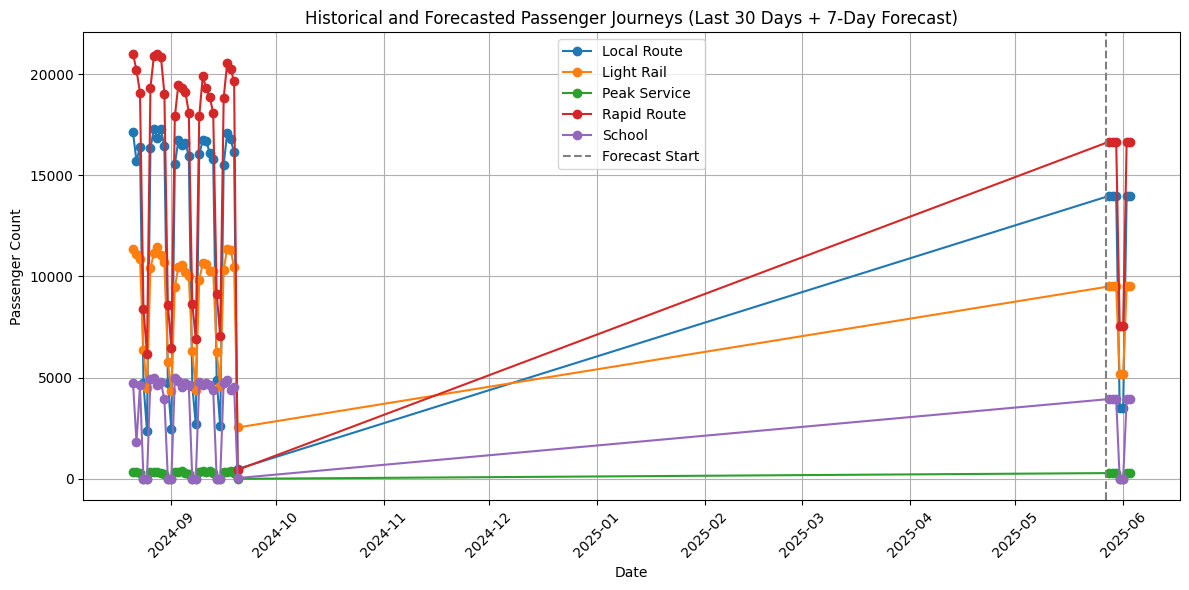

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Step 1: Read and preprocess the data
def preprocess_data(file_path):
    # Read CSV file
    df = pd.read_csv(file_path)

    # Convert Date to datetime
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

    # Filter out anomalies (Local Route < 100)
    df = df[df['Local Route'] > 100]

    # Add weekday/weekend indicator
    df['IsWeekend'] = df['Date'].dt.dayofweek.isin([5, 6])

    # Sort by date
    df = df.sort_values('Date')

    # Ensure numeric columns
    service_types = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']
    for col in service_types:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    return df

# Step 2: Compute 7-day moving averages for weekdays and weekends
def compute_moving_averages(df, service_types, window=7, days=60):
    # Filter recent data (last 60 days)
    recent_df = df[df['Date'] >= df['Date'].max() - timedelta(days=days)]

    # Initialize dictionary to store averages
    averages = {'Weekday': {}, 'Weekend': {}}

    for service in service_types:
        # Weekday moving average
        weekday_data = recent_df[~recent_df['IsWeekend']][service]
        if len(weekday_data) >= window:
            averages['Weekday'][service] = round(weekday_data[-window:].mean())
        else:
            averages['Weekday'][service] = round(weekday_data.mean())

        # Weekend moving average
        weekend_data = recent_df[recent_df['IsWeekend']][service]
        if len(weekend_data) >= window:
            averages['Weekend'][service] = round(weekend_data[-window:].mean())
        else:
            averages['Weekend'][service] = round(weekend_data.mean())

    return averages

# Step 3: Generate 7-day forecast
def generate_forecast(averages, start_date='2025-05-28', days=7):
    forecast = []
    start = pd.to_datetime(start_date)

    for i in range(days):
        date = start + timedelta(days=i)
        is_weekend = date.weekday() >= 5
        period = 'Weekend' if is_weekend else 'Weekday'

        # Initialize forecast row
        row = {'Date': date.strftime('%Y-%m-%d')}

        # Assign moving averages
        for service in averages[period]:
            if is_weekend and service in ['Peak Service', 'School']:
                row[service] = 0  # Set to 0 for weekends
            else:
                row[service] = averages[period][service]

        forecast.append(row)

    return pd.DataFrame(forecast)

# Step 4: Visualize historical data and forecast
def plot_forecast(df, forecast_df, service_types):
    # Filter last 30 days for visualization
    recent_df = df[df['Date'] >= df['Date'].max() - timedelta(days=30)]

    # Combine historical and forecast data
    forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])
    combined_df = pd.concat([recent_df[['Date'] + service_types], forecast_df[['Date'] + service_types]])

    # Plot
    plt.figure(figsize=(12, 6))
    for service in service_types:
        plt.plot(combined_df['Date'], combined_df[service], label=service, marker='o' if service in forecast_df.columns else '')

    # Add vertical line to separate historical and forecast data
    plt.axvline(x=pd.to_datetime('2025-05-27'), color='gray', linestyle='--', label='Forecast Start')

    plt.title('Historical and Forecasted Passenger Journeys (Last 30 Days + 7-Day Forecast)')
    plt.xlabel('Date')
    plt.ylabel('Passenger Count')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('passenger_forecast.png')  # Save plot as PNG
    plt.show()

# Main execution
def main():
    # File path in Colab
    file_path = '/content/Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250527.csv'

    # Preprocess data
    df = preprocess_data(file_path)

    # Define service types
    service_types = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']

    # Compute moving averages
    averages = compute_moving_averages(df, service_types, window=7, days=60)

    # Generate forecast
    forecast_df = generate_forecast(averages, start_date='2025-05-28', days=7)

    # Display forecast
    print("\n7-Day Passenger Forecast (May 28, 2025 – June 3, 2025):")
    print(forecast_df.to_string(index=False))

    # Plot historical and forecast data
    plot_forecast(df, forecast_df, service_types)

# Run the forecast
if __name__ == "__main__":
    main()